# Preference Alignment with Direct Preference Optimization (DPO)

This notebook will guide you through the process of fine-tuning a language model using Direct Preference Optimization (DPO). We will use the SmolLM2-135M-Instruct model which has already been through a SFT training, so it it compatible with DPO. You can also use the model you trained in [1_instruction_tuning](../../1_instruction_tuning/notebooks/sft_finetuning_example.ipynb).

<div style='background-color: lightblue; padding: 10px; border-radius: 5px; margin-bottom: 20px; color:black'>
     <h2 style='margin: 0;color:blue'>Exercise: Aligning SmolLM2 with DPOTrainer</h2>
     <p>Take a dataset from the Hugging Face hub and align a model on it. </p>
     <p><b>Difficulty Levels</b></p>
     <p>🐢 Use the `trl-lib/ultrafeedback_binarized` dataset</p>
     <p>🐕 Try out the `argilla/ultrafeedback-binarized-preferences` dataset</p>
     <p>🦁 Select a dataset that relates to a real-world use case you’re interested in, or use the model you trained in
        <a href="../../1_instruction_tuning/notebooks/sft_finetuning_example.ipynb">1_instruction_tuning</a></p>
</div>

In [1]:
# Install the requirements in Google Colab
# !pip install transformers datasets trl huggingface_hub

# Authenticate to Hugging Face

from huggingface_hub import login

login()

# for convenience you can create an environment variable containing your hub token as HF_TOKEN

In [3]:
!pip install transformers datasets trl huggingface_hub

## Import libraries


In [4]:
import torch
import os
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from trl import DPOTrainer, DPOConfig

## Format dataset

In [5]:
# Load dataset

# TODO: 🦁🐕 change the dataset to one of your choosing
dataset = load_dataset(path="trl-lib/ultrafeedback_binarized", split="train")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/643 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/131M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.14M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/62135 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [15]:
dataset[0]

{'chosen': [{'content': 'Use the pygame library to write a version of the classic game Snake, with a unique twist', 'role': 'user'}, {'content': "Sure, I'd be happy to help you write a version of the classic game Snake using the pygame library! Here's a basic outline of how we can approach this:\n\n1. First, we'll need to set up the game display and create a game object that we can use to handle the game's state.\n2. Next, we'll create the game's grid, which will be used to represent the game board. We'll need to define the size of the grid and the spaces within it.\n3. After that, we'll create the snake object, which will be used to represent the player's movement. We'll need to define the size of the snake and the speed at which it moves.\n4. We'll also need to create a food object, which will be used to represent the food that the player must collect to score points. We'll need to define the location of the food and the speed at which it moves.\n5. Once we have these objects set up,

In [21]:
# TODO: 🐕 If your dataset is not represented as conversation lists, you can use the `process_dataset` function to convert it.
from typing import Dict


def return_prompt_and_responses(samples):
    return {
        "prompt": [
            "Question: " + question + "\n\nAnswer: "
            for question in samples["question"]
        ],
        "chosen": samples["response_j"],   # rated better than k
        "rejected": samples["response_k"], # rated worse than j
    }

dataset = load_dataset(
    "lvwerra/stack-exchange-paired",
    split="train",
    data_dir="data/rl"
)
original_columns = dataset.column_names

dataset.map(
    return_prompt_and_responses,
    batched=True,
    remove_columns=original_columns
)

README.md:   0%|          | 0.00/737 [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

train-00000-of-00020.parquet:   0%|          | 0.00/315M [00:00<?, ?B/s]

train-00001-of-00020.parquet:   0%|          | 0.00/313M [00:00<?, ?B/s]

train-00002-of-00020.parquet:   0%|          | 0.00/313M [00:00<?, ?B/s]

train-00003-of-00020.parquet:   0%|          | 0.00/314M [00:00<?, ?B/s]

train-00004-of-00020.parquet:   0%|          | 0.00/315M [00:00<?, ?B/s]

train-00005-of-00020.parquet:   0%|          | 0.00/313M [00:00<?, ?B/s]

train-00006-of-00020.parquet:   0%|          | 0.00/314M [00:00<?, ?B/s]

train-00007-of-00020.parquet:   0%|          | 0.00/312M [00:00<?, ?B/s]

train-00008-of-00020.parquet:   0%|          | 0.00/314M [00:00<?, ?B/s]

train-00009-of-00020.parquet:   0%|          | 0.00/312M [00:00<?, ?B/s]

train-00010-of-00020.parquet:   0%|          | 0.00/313M [00:00<?, ?B/s]

train-00011-of-00020.parquet:   0%|          | 0.00/314M [00:00<?, ?B/s]

train-00012-of-00020.parquet:   0%|          | 0.00/312M [00:00<?, ?B/s]

train-00013-of-00020.parquet:   0%|          | 0.00/313M [00:00<?, ?B/s]

train-00014-of-00020.parquet:   0%|          | 0.00/312M [00:00<?, ?B/s]

train-00015-of-00020.parquet:   0%|          | 0.00/313M [00:00<?, ?B/s]

train-00016-of-00020.parquet:   0%|          | 0.00/313M [00:00<?, ?B/s]

train-00017-of-00020.parquet:   0%|          | 0.00/314M [00:00<?, ?B/s]

train-00018-of-00020.parquet:   0%|          | 0.00/312M [00:00<?, ?B/s]

train-00019-of-00020.parquet:   0%|          | 0.00/313M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/42 [00:00<?, ?it/s]

Map:   0%|          | 0/7435908 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'chosen', 'rejected'],
    num_rows: 7435908
})

## Select the model

We will use the SmolLM2-135M-Instruct model which has already been through a SFT training, so it it compatible with DPO. You can also use the model you trained in [1_instruction_tuning](../../1_instruction_tuning/notebooks/sft_finetuning_example.ipynb).


<div style='background-color: lightblue; padding: 10px; border-radius: 5px; margin-bottom: 20px; width:80%; color:black'>
     <p>🦁 change the model to the path or repo id of the model you trained in <a href="../../1_instruction_tuning/notebooks/sft_finetuning_example.ipynb">1_instruction_tuning</a></p>
</div>


In [24]:
# https://huggingface.co/blog/dpo-trl

# Load model directly
from transformers import AutoModelForCausalLM
from transformers import BitsAndBytesConfig


bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)


model_name = "LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

model.config.use_cache = False
tokenizer = AutoTokenizer.from_pretrained(model_name)




PackageNotFoundError: No package metadata was found for bitsandbytes

In [25]:
# TODO: 🦁 change the model to the path or repo id of the model you trained in [1_instruction_tuning](../../1_instruction_tuning/notebooks/sft_finetuning_example.ipynb)
model_name = "HuggingFaceTB/SmolLM2-135M-Instruct"

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

# Model to fine-tune
model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=model_name,
    torch_dtype=torch.float32,
).to(device)
model.config.use_cache = False
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Set our name for the finetune to be saved &/ uploaded to
finetune_name = "SmolLM2-FT-DPO"
finetune_tags = ["smol-course", "module_1"]

## Train model with DPO

In [26]:
# Training arguments
training_args = DPOConfig(
    # Training batch size per GPU
    per_device_train_batch_size=4,
    # Number of updates steps to accumulate before performing a backward/update pass
    # Effective batch size = per_device_train_batch_size * gradient_accumulation_steps
    gradient_accumulation_steps=4,
    # Saves memory by not storing activations during forward pass
    # Instead recomputes them during backward pass
    gradient_checkpointing=True,
    # Base learning rate for training
    learning_rate=5e-5,
    # Learning rate schedule - 'cosine' gradually decreases LR following cosine curve
    lr_scheduler_type="cosine",
    # Total number of training steps
    max_steps=200,
    # Disables model checkpointing during training
    save_strategy="no",
    # How often to log training metrics
    logging_steps=1,
    # Directory to save model outputs
    output_dir="smol_dpo_output",
    # Number of steps for learning rate warmup
    warmup_steps=100,
    # Use bfloat16 precision for faster training
    bf16=True,
    # Disable wandb/tensorboard logging
    report_to="none",
    # Keep all columns in dataset even if not used
    remove_unused_columns=False,
    # Enable MPS (Metal Performance Shaders) for Mac devices
    use_mps_device=device == "mps",
    # Model ID for HuggingFace Hub uploads
    hub_model_id=finetune_name,
    # DPO-specific temperature parameter that controls the strength of the preference model
    # Lower values (like 0.1) make the model more conservative in following preferences
    beta=0.1,
    # Maximum length of the input prompt in tokens
    max_prompt_length=1024,
    # Maximum combined length of prompt + response in tokens
    max_length=1536,
)

In [ ]:
trainer = DPOTrainer(
    # The model to be trained
    model=model,
    # Training configuration from above
    args=training_args,
    # Dataset containing preferred/rejected response pairs
    train_dataset=dataset,
    # Tokenizer for processing inputs
    processing_class=tokenizer,
    # DPO-specific temperature parameter that controls the strength of the preference model
    # Lower values (like 0.1) make the model more conservative in following preferences
    # beta=0.1,
    # Maximum length of the input prompt in tokens
    # max_prompt_length=1024,
    # Maximum combined length of prompt + response in tokens
    # max_length=1536,
)

Extracting prompt in train dataset:   0%|          | 0/7435908 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/7435908 [00:00<?, ? examples/s]

In [ ]:
# Train the model
trainer.train()

# Save the model
trainer.save_model(f"./{finetune_name}")

# Save to the huggingface hub if login (HF_TOKEN is set)
# if os.getenv("HF_TOKEN"):
#     trainer.push_to_hub(tags=finetune_tags)

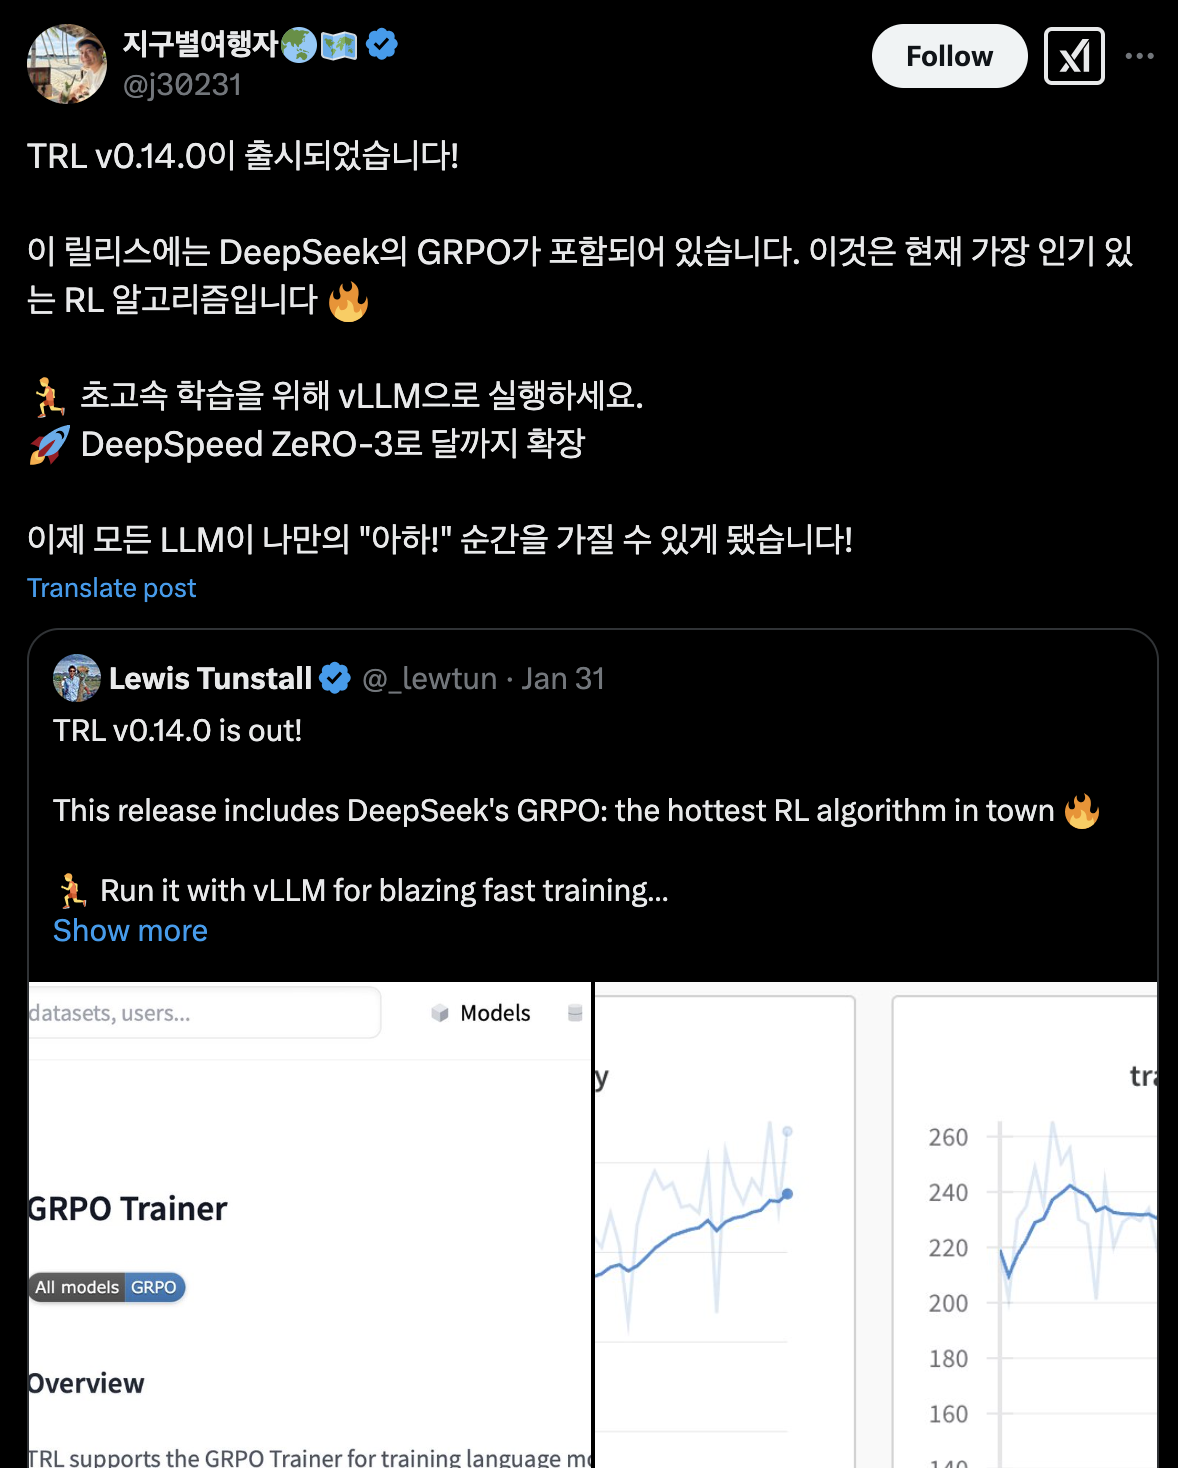

## 💐 You're done!

This notebook provided a step-by-step guide to fine-tuning the `HuggingFaceTB/SmolLM2-135M` model using the `DPOTrainer`. By following these steps, you can adapt the model to perform specific tasks more effectively. If you want to carry on working on this course, here are steps you could try out:

- Try this notebook on a harder difficulty
- Review a colleagues PR
- Improve the course material via an Issue or PR.